### Table of Contents

#### 1. Random Forest Baseline Model

#### 2. Manually Fine-Tuning of Hyperparameters

#### 3. Model Evaluation

#### 4. Conclusion

### Data Dictionary

The dataset is created by joining 5 tables and added dummy columns. For an overview of the data, please refer to the following data dictionary:

#### 1. sales columns

**store_nbr**: the store at which the products are sold.

**family**: the type of product sold.

**sales**: the total sales for a product family at a particular store on a given date. Fractional values are possible since products can be sold in

fractional units (e.g., 1.5 kg of cheese, as opposed to 1 bag of chips).

**onpromotion**: the total number of items in a product family that were being promoted at a store on a given date.

#### 2. stores columns

Store metadata, including **city, state, type, and cluster**.

cluster is a grouping of similar stores.

#### 3. oil column

**Daily oil price**. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 4. holidays_events columns

Holidays and Events, with metadata

NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to

another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for 

the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which 

means it was celebrated on 2012-10-12. 

Days that are type **Bridge** are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made 

up by the type **Work Day** which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

**Additional** holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (m aking Christmas Eve a holiday).

#### 5. Additional Notes on events

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which 

greatly affected supermarket sales for several weeks after the earthquake

#### The initial performance of the baseline Random Forest model showed promise, but overfitting was a concern. To address this, I attempted GridSearchCV and RandomSearchCV for hyperparameter tuning. However, due to their computational intensity, I opted to manually iterate over a parameter grid using a single train-validation split. This approach yielded a more robust model with some improvement. Initially, my baseline

#### Random Forest scores were: training accuracy of 1, validation accuracy of 0.95, and testing accuracy of 0.91. After fine-tuning, the scores improved to: training accuracy of 0.96, validation accuracy of 0.95, and testing accuracy of 0.91.

#### To further enhance performance, I removed 5 extreme outliers caused by rare earthquake cases and will continue iterating over the process below.

In [1]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
import sklearn as skl

In [16]:
np.__version__

'1.26.4'

In [17]:
skl.__version__

'1.2.2'

In [2]:
# read data
df=pd.read_csv("full_data_dropped_dummies.csv")
df.head()

,sales,onpromotion,store_trans,dcoilwtico_interpolated,store_nbr_1,store_nbr_10,store_nbr_17,store_nbr_18,store_nbr_2,store_nbr_3,...,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito,year,month,day,weekday,weekend
0,1091.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
1,1060.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
2,579.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
3,2652.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0
4,0.0,0,2111.0,93.14,1,0,0,0,0,0,...,0,0,0,0,0,2013,1,2,3,0


#### Split the dataset

In [3]:
# train_validation_test split
from sklearn.model_selection import train_test_split
X=df.drop("sales", axis=1)
y=df["sales"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

### 1. Random Forest Baseline Model

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [5]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train2,y_train2)
y_train2_pred = rf.predict(X_train2)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)
print(f"baseline train r squared: {r2_score(y_train2,y_train2_pred):.2f}")
print(f"baseline validation r squared: {r2_score(y_val,y_val_pred):.2f}")
print(f"baseline test r squared: {r2_score(y_test,y_test_pred):.2f}")

baseline train r squared: 0.99
baseline validation r squared: 0.96
baseline test r squared: 0.96


### 2. Manually iterate over parameter grid.

In [4]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [20,40,60],
    'min_samples_leaf': [5,10,25]
}

In [7]:
# Iterate over all combinations of hyperparameters
from sklearn.model_selection import ParameterGrid
best_score = 0
best_params = None
for params in ParameterGrid(param_grid):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    rf.fit(X_train2, y_train2)

    # Evaluate on validation set
    y_val_pred = rf.predict(X_val)
    val_r2 = r2_score(y_val, y_val_pred)
    # Keep track of the best model
    if val_r2 > best_score:
        best_score = val_r2
        best_params = params

In [8]:
# Train the best model on the entire training set with best parameters
best_rf = RandomForestRegressor(random_state=42, **best_params)
best_rf.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=40, min_samples_leaf=5, n_estimators=300,
                      random_state=42)

In [9]:
import pickle
with open("best_rf.pkl","wb") as file:
    pickle.dump(best_rf,file)

In [8]:
# Evaluate on training and validation sets with best model
y_train2_pred = best_rf.predict(X_train2)
y_val_pred = best_rf.predict(X_val)

print(f"Best parameters: {best_params}")
print(f"Train R² score: {r2_score(y_train2, y_train2_pred):.2f}")
print(f"Validation R² score: {r2_score(y_val, y_val_pred):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train2, y_train2_pred):.2f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"Train MSE: {mean_squared_error(y_train2, y_train2_pred):.2f}")
print(f"Validation MSE: {mean_squared_error(y_val, y_val_pred):.2f}")

Best parameters: {'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 300}
Train R² score: 0.97
Validation R² score: 0.96
Train MAE: 212.13
Validation MAE: 294.42
Train MSE: 238685.23
Validation MSE: 379385.96


**A robust model achieved, we will proceed to make predictions.**

In [9]:
y_test_pred = best_rf.predict(X_test)
print(f"Test R² score: {r2_score(y_test, y_test_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.2f}")

Test R² score: 0.96
Test MAE: 297.17
Test MSE: 387662.80


### 3. Model Evaluation

#### 3.1 Feature Importance

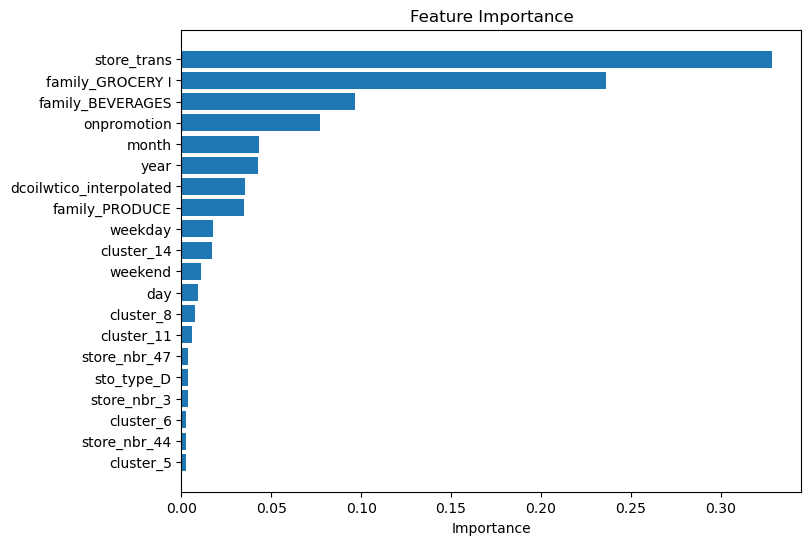

In [14]:
# Check for important features of the best model
feature_importances = best_rf.feature_importances_
features = X_train2.columns

# Create a DataFrame for better visualization
feature_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_df['feature'][:20], feature_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

#### 3.2 Error Analysis

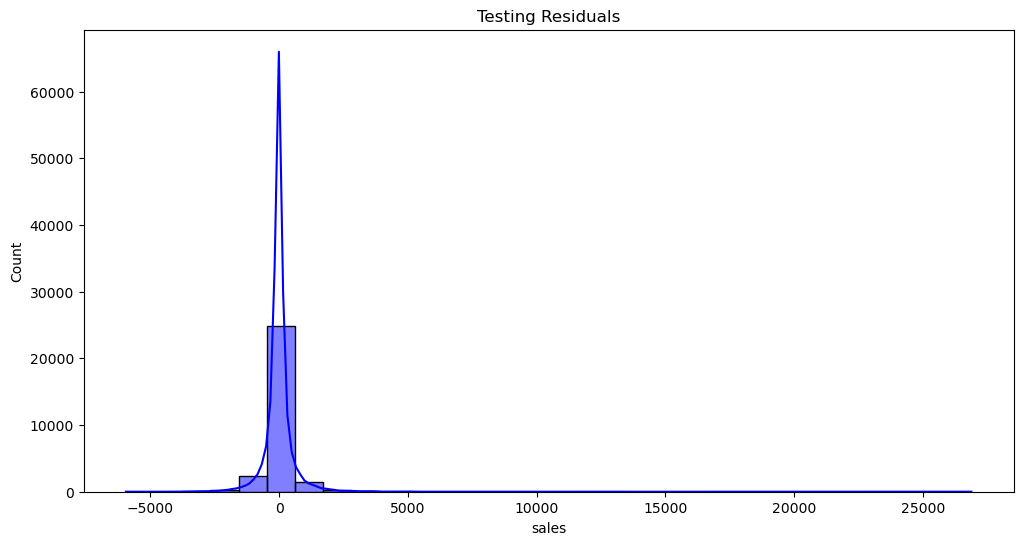

In [11]:
# Calculate residuals
test_residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(12, 6))
sns.histplot(test_residuals, kde=True, bins=30, color='blue')
plt.title('Testing Residuals')

plt.show()

### 4. Conclusion: 

- #### RF outperformed all other models with the least effort in fine-tuning hyperparameters, but its computation time is significantly longer. 
- #### Linear Regression's top important features are store_trans, GroceryI, store type A, onpromotion, year, cluster5, Cleaning, and daily oil price. Both Decision Tree and Random Forest have store_trans, GroceryI, Beverages, onpromotion, daily oil price, year, month, and Produce as their top 7 features. There are minor differences between DT and RF.

- #### Error Analysis: 1. High density near zero, suggesting that the model is generally accurate; 2. Long right tail, suggesting the model significantly underestimate some actual values due to the remaining outliers in the dataset.
- #### After removing the 5 extreme outliers, test R2 jumped from 0.91 to 0.96.
- #### The model works best when the sales units are below 8,343. Its performance decreases when sales units are between 8,344 and 38,422, and it performs poorly when sales units exceed 38,422.
